* `Import Libraries`

In [2]:
import numpy as np 
import pandas as pd 
import joblib 
import wordcloud
import os 
import re 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

import nltk
import spacy
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to C:\Users\Abdallah
[nltk_data]     Samir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Abdallah
[nltk_data]     Samir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

* `Read The Dataset`

In [3]:
FILE_PATH = os.path.join(os.getcwd(),"IMDB Dataset.csv") 
df = pd.read_csv(FILE_PATH) 
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


* `EDA`

In [4]:
df.shape

(50000, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
df["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [8]:
df["sentiment"] = df["sentiment"].map({'positive':1,'negative':0})
df["sentiment"].value_counts() 

sentiment
1    25000
0    25000
Name: count, dtype: int64

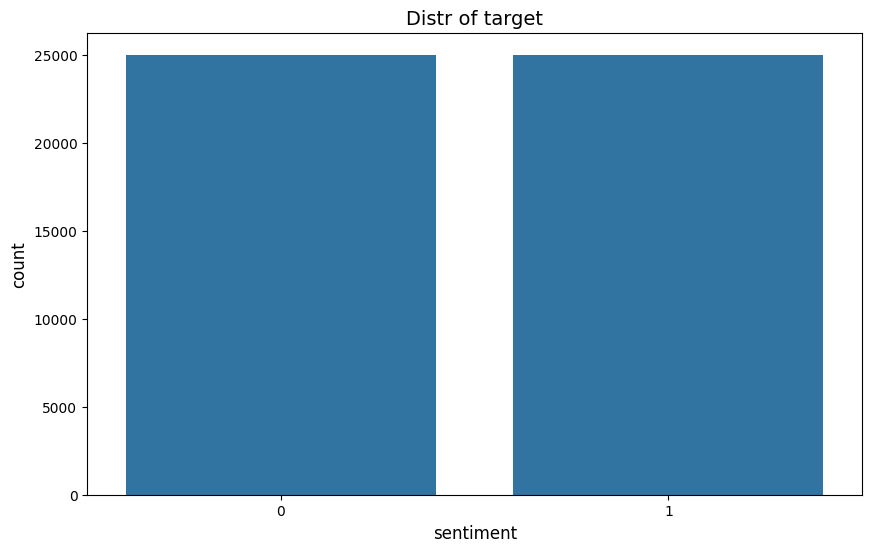

In [9]:
plt.figure(figsize=(10,6)) 
sns.countplot(data=df,x='sentiment') 
plt.title('Distr of target',fontsize=14,c='k') 
plt.xlabel('sentiment',c='k',fontsize=12) 
plt.ylabel('count',c='k',fontsize=12)
plt.show()

* `Text Cleaning & Vizualization`

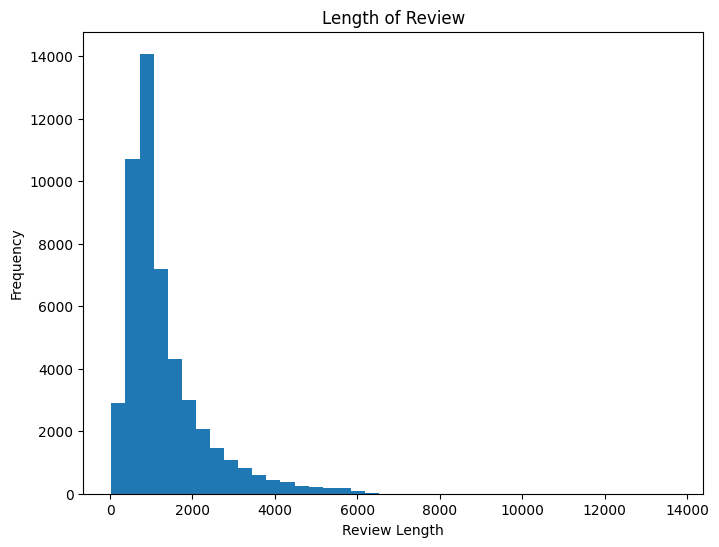

In [10]:
# Sequence Length
length_review = df['review'].str.len()
plt.figure(figsize=(8, 6))
plt.hist(length_review, bins=40)
plt.title('Length of Review')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Remove unwanted text patterns from the review
def remove_pattern(input_text,pattern):
    return re.sub(pattern,' ',input_text)

* `Remove Punctuation, Numbers, Special Chars`

In [12]:
# Remove special characters and digits and Convert to lowercase
df['review'] = df['review'].str.lower()
df.loc[:,'review'] = df['review'].apply(lambda x :remove_pattern(x,r'[^a-zA-Z\s]'))
df.loc[:,'review'] = df['review'].str.replace('\s+', ' ',regex=True)
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


#### `Remove Repeated Characters`

In [13]:
# A Function to remove excessive repeated chars while preserving correct words
def remove_excessive_repeated_characters(input_string, max_repeats=2):
    # Define a regular expression pattern to match consecutive repeated characters
    pattern = f"(\\w)\\1{{{max_repeats},}}"
    # Replace the matched pattern with a single occurrence of the character
    cleaned_string = re.sub(pattern, r"\1", input_string)
    
    return cleaned_string

# Apply the above function
df.loc[:, 'review'] = df['review'].apply(remove_excessive_repeated_characters)
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


* `Removing short words`

In [14]:
df.loc[:, 'review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
df.head()

,review,sentiment
0,other reviewers mentioned that after watching ...,1
1,wonderful little production filming technique ...,1
2,thought this wonderful spend time summer weeke...,1
3,basically there family where little jake think...,0
4,petter mattei love time money visually stunnin...,1


* `Remove Numbers from Words`

In [15]:
df.loc[:, 'review'] = df['review'].apply(lambda x: remove_pattern(x, '(?<=\w)\d+|\d+(?=\w)'))
df.head()

,review,sentiment
0,other reviewers mentioned that after watching ...,1
1,wonderful little production filming technique ...,1
2,thought this wonderful spend time summer weeke...,1
3,basically there family where little jake think...,0
4,petter mattei love time money visually stunnin...,1


* `Remove Special Chars`

In [16]:
df.loc[:, 'review'] = df['review'].apply(lambda x: remove_pattern(x, r'[!@#$%^&*()_+{}\[\]:;<>,.?~\\|\/]'))
df.head()

,review,sentiment
0,other reviewers mentioned that after watching ...,1
1,wonderful little production filming technique ...,1
2,thought this wonderful spend time summer weeke...,1
3,basically there family where little jake think...,0
4,petter mattei love time money visually stunnin...,1


* `Rmeove Redundant words`

In [17]:
# A Function to remove redundant words like (I've, You'll)
# Again, It is challenging

def remove_redundant_words_extra_spaces(text: str):
    # Remove contractions using regular expressions
    contraction_pattern = re.compile(r"'\w+|\w+'\w+|\w+'")
    text = contraction_pattern.sub('', text)

    # Define a set of stopwords
    stop_words = set(stopwords.words("english"))

    # Remove stopwords and extra spaces
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    clean_text = ' '.join(filtered_words)

    # Remove extra spaces
    clean_text = ' '.join(clean_text.split())
    
    return clean_text


# Apply the above function
df.loc[:, 'review'] = df['review'].apply(remove_redundant_words_extra_spaces)
df.head()

,review,sentiment
0,reviewers mentioned watching episode hooked ri...,1
1,wonderful little production filming technique ...,1
2,thought wonderful spend time summer weekend si...,1
3,basically family little jake thinks zombie clo...,0
4,petter mattei love time money visually stunnin...,1


In [18]:
# Create a folder for cleaned dataset
Cleaned_Dataset = os.path.join(os.getcwd(),'cleaned_dataset') 
os.makedirs(Cleaned_Dataset,exist_ok=True) 

In [19]:
# Download the dataset here at this step before Lemmatizing
df.to_csv(os.path.join(Cleaned_Dataset, "cleaned_dataset_1.csv"), index=False)

* `Tokenization`

In [20]:
tokenize_review = df['review'].apply(lambda x : word_tokenize(x)) 
tokenize_review.head()

0    [reviewers, mentioned, watching, episode, hook...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, spend, time, summer, week...
3    [basically, family, little, jake, thinks, zomb...
4    [petter, mattei, love, time, money, visually, ...
Name: review, dtype: object

In [21]:
lemmatizer = WordNetLemmatizer() 
tokenize_review = tokenize_review.apply(lambda x:[lemmatizer.lemmatize(i) for i in x]) 
tokenize_review

0        [reviewer, mentioned, watching, episode, hooke...
1        [wonderful, little, production, filming, techn...
2        [thought, wonderful, spend, time, summer, week...
3        [basically, family, little, jake, think, zombi...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [thought, movie, right, good, creative, origin...
49996    [plot, dialogue, acting, idiotic, directing, a...
49997    [catholic, taught, parochial, elementary, scho...
49998    [going, disagree, previous, comment, side, mal...
49999    [expects, star, trek, movie, high, fan, expect...
Name: review, Length: 50000, dtype: object

In [22]:
df.loc[:,'review'] = tokenize_review.apply(lambda x : ' '.join(x)) 
df.head()


,review,sentiment
0,reviewer mentioned watching episode hooked rig...,1
1,wonderful little production filming technique ...,1
2,thought wonderful spend time summer weekend si...,1
3,basically family little jake think zombie clos...,0
4,petter mattei love time money visually stunnin...,1


In [23]:
os.path.join(Cleaned_Dataset,'cleaned_dataset_2.csv')

'c:\\Users\\Abdallah Samir\\Desktop\\ELEVVO\\src\\notebooks\\cleaned_dataset\\cleaned_dataset_2.csv'

* `Some Viz with Wordcloud`

* `Bonus`

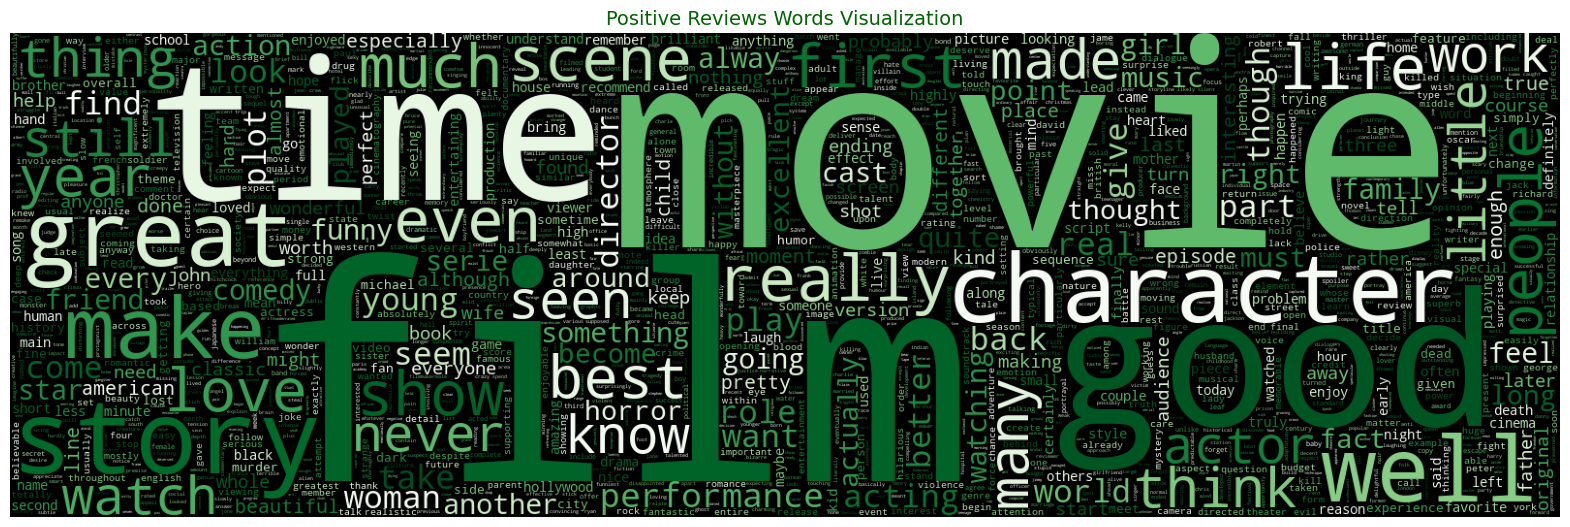

In [24]:
# POSITIVE WORDS CLOUD
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filter positive reviews only (assuming sentiment column: 1 = positive, 0 = negative)
positive_df = df[df['sentiment'] == 1]

# Create word cloud for positive reviews
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
               background_color='black', collocations=False, 
               colormap='Greens').generate(' '.join(positive_df['review'].astype(str)))
plt.title('Positive Reviews Words Visualization', fontsize=14, c='darkgreen')
plt.imshow(wc)
plt.axis('off') 
plt.show()

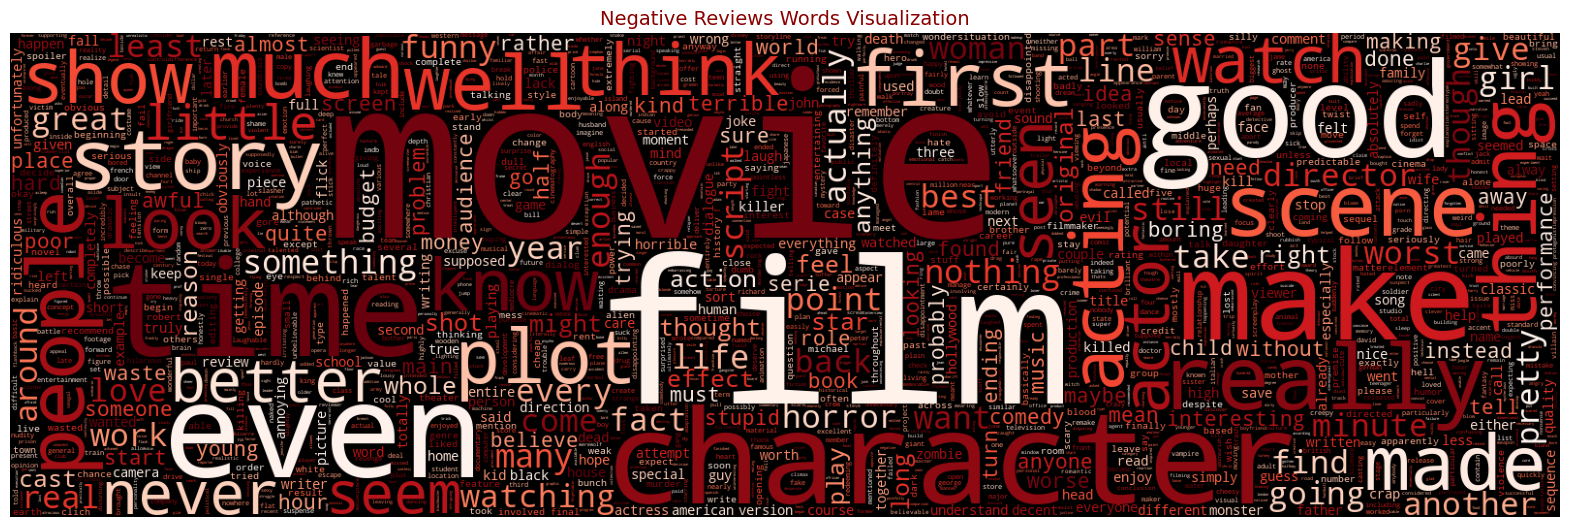

In [25]:
# NEGATIVE WORDS CLOUD
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filter negative reviews only (assuming sentiment column: 1 = positive, 0 = negative)
negative_df = df[df['sentiment'] == 0]

# Create word cloud for negative reviews
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
               background_color='black', collocations=False, 
               colormap='Reds').generate(' '.join(negative_df['review'].astype(str)))
plt.title('Negative Reviews Words Visualization', fontsize=14, c='darkred')
plt.imshow(wc)
plt.axis('off') 
plt.show()

* ` Text Vectorization`

* ` CountVectorizer(BOW)`

In [26]:
bow_vectorizer = CountVectorizer(max_df=0.90,min_df=4,max_features=5000,stop_words='english') 
X_bow = bow_vectorizer.fit_transform(df['review']) 
X_bow = X_bow.todense() 
X_bow

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [27]:
X_bow.shape

(50000, 5000)

In [28]:
ARTIFACTS_FOLDER_PATH = os.path.join(os.getcwd(), '..', 'artifacts')
os.makedirs(ARTIFACTS_FOLDER_PATH, exist_ok=True)

In [29]:
# dump the bow_vectorizer
joblib.dump(bow_vectorizer, os.path.join(ARTIFACTS_FOLDER_PATH, 'bow_vectorizer.pkl'))

['c:\\Users\\Abdallah Samir\\Desktop\\ELEVVO\\src\\notebooks\\..\\artifacts\\bow_vectorizer.pkl']

* `2. TF-IDF` 

In [30]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['review'])
X_tfidf = X_tfidf.toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
X_tfidf.shape 

(50000, 5000)

In [32]:
X = X_tfidf
y = df['sentiment']

In [33]:
joblib.dump(tfidf_vectorizer, os.path.join(ARTIFACTS_FOLDER_PATH, 'tfidf_vectorizer.pkl'))

['c:\\Users\\Abdallah Samir\\Desktop\\ELEVVO\\src\\notebooks\\..\\artifacts\\tfidf_vectorizer.pkl']

* `Split the data`

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X_tfidf,y,test_size=0.2,random_state=45,shuffle=True,stratify=y)

* `Building Models`

* `LogisticRegression`

In [35]:
log_clf = LogisticRegression(C=1.5,max_iter=1000,random_state=45)
log_clf.fit(X_train,y_train )

# Predict and evaluate
y_pred_train_log = log_clf.predict(X_train)
y_pred_test_log = log_clf.predict(X_test)

# Using f1_score
score_train_log = accuracy_score(y_train, y_pred_train_log)
score_test_log = accuracy_score(y_test, y_pred_test_log)

print(f'The accuracy_score using Logistic model for Training Dataset is {score_train_log*100:.3f}')
print(f'The accuracy_score using Logistic model for Testing Dataset  is {score_test_log*100:.3f}')

The accuracy_score using Logistic model for Training Dataset is 91.170
The accuracy_score using Logistic model for Testing Dataset  is 88.410


* ` NAIVE BAYES CLASSIFIER`

In [37]:
# NAIVE BAYES CLASSIFIER
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Train Naive Bayes model with tuned parameters
nb_clf = MultinomialNB(alpha=0.2, fit_prior=True)
nb_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_train_nb = nb_clf.predict(X_train)
y_pred_test_nb = nb_clf.predict(X_test)

# Calculate accuracy scores
score_train_nb = accuracy_score(y_train, y_pred_train_nb)
score_test_nb = accuracy_score(y_test, y_pred_test_nb)

print(f'The accuracy_score using Naive Bayes model for Training Dataset is {score_train_nb*100:.3f}')
print(f'The accuracy_score using Naive Bayes model for Testing Dataset  is {score_test_nb*100:.3f}')

The accuracy_score using Naive Bayes model for Training Dataset is 86.133
The accuracy_score using Naive Bayes model for Testing Dataset  is 85.580
